In [6]:
#Import Statements

import pandas as pd #Pandas to handle dataframe operations
import numpy as np  #Numpy to handle array operations
from sklearn.preprocessing import MinMaxScaler  #Scaler to normalize the data
import matplotlib.pyplot as plt #Plotting toolbox

import yahoo_fin.stock_info as si   #Yahoo Finance data Api for python

import talib    #Technical Analysis Library for financial data
from mplfinance.original_flavor import candlestick_ohlc   #Plotting tool for obtaining candlestick for Open High Low Close data

from matplotlib.pylab import date2num      #Convert datetime objects to Matplotlib dates.
from datetime import timedelta  #Used to handle duration

from scipy.stats import pearsonr #Used to obtain the pearson R coefficient for asset correlation

import tensorflow as tf   #Tensorflow for deeplearning
from tensorflow.keras import Sequential    #Sequential Api for model defination
#Dense for standard output
#LSTM for RNN cell to model the financial data
#Dropout for dropout regularization to prevent overfitting
from tensorflow.keras.layers import Dense, LSTM, Dropout   

import sys,os
sys.version                                    

'3.8.6 (default, Nov 20 2020, 18:29:40) \n[Clang 12.0.0 (clang-1200.0.32.27)]'

In [7]:
base_path = None    #Define base path or system will try to interpret the base path from sys
path = (base_path or sys.path[0]) + '/data/'    #The input variables are located inside the data folder at the base path
result_path = path + 'results/'    #All outputs will be exported to the result_path
input_path = path+'stocks_input.xls'    #The stocks input path. The data is read in the form of an excel sheet as given in the sample.
external_stock_input_path = path + 'external_stocks.txt'    #The stock list that are candidates for addition are listed here.
if not os.path.exists(result_path):
    #Check if the result folder already exists. If not create the folder.
    os.mkdir(result_path)

model_name = path + "portfolio_predictor_5.hdf5"    #Weights file. This allows the system to load on pre-trained weights to train and analyze fast.

In [8]:
#Variable to decide if image outputs are to be written to disk
#If true, all images will be written to result_path
img_save = False 

In [9]:
training_window = 60    #Duration of time for which the stock data is analyzed for projection
prediction_window = 5   #Duration of time for which the stock feature like opening price is projected to.
#Thus if the training_window is 60, and the prediction window is 5 and the date today is 1st January, the stock data will be analyzed for November and December to predict the stock data on 5th of January.

split_date = '2020-01-01'   #This is used to split the training and test data. If the split date is 2020-01-01, the data before this is used for training, and the data after this is used for testing.

target_prediction_indices = (0,-3,-2)   #Indices of final datafame that are predicted by the neural network. 0 refers to opening price. -3 to returns and -2 to volatility.

cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'] #Columns of data pulled from the stock reposity
cols_to_drop = ["Date", "adjclose", "ticker"]   #Cols that are to be dropped.
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [264]:
def get_indicators(data, window=100):
    '''
    This adds columns of financial analysis output to the dataframe data on the basis of existing data like closing prices. The analysis is mainly done by Ta-Lib.
    :param data: Dataframe containing opening, high, low and closing prices of stock portfolio
    :return: talib financial analysis columns on the existing dataframe
    '''
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    # Compute the logarithmic returns using the Closing price 
    data['Log_Ret'] = np.log(data['close'] / data['close'].shift(100))

    # Compute Volatility using the pandas rolling standard deviation function
    data['volatility'] = data['Log_Ret'].rolling(window=window ).std() * np.sqrt(21)
    
    #Compute the Sharpe Ratio 
    data["Sharpe Ratio"] = data["Log_Ret"]/data["volatility"]
    print(data.dropna())
    return data.dropna()

In [11]:
def plot_chart(data, n, fileName="Current Portfolio", save=False):
    '''
    Function to plot the data features
    :param data: Dataframe containing opening, high, low and closing prices of stock portfolio
    :param n: time frame for which to show the plot.
    :param filename: Filename of the file to be saved.
    :param save: If set to fale, do not write to disk.

    '''
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(result_path + fileName + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [12]:
def load_external_stocks(path):
    '''
    Function to load external stocks from file.
    :param path: path from which to load the file
    :return: list of external stocks.
    '''
    f = open(path)
    a = f.readlines()
    a = [i.rstrip() for i in a]
    return a

#load_external_stocks(external_stock_input_path)

In [13]:
def load_stocks(path):
    '''
    Function to external stocks from excel.
    :param path: path from which to load the file
    :return: dictionary of stocks and allocation.
    '''
    _df = pd.read_excel(path)
    return _df.set_index("Ticker").to_dict()

stdf = load_stocks(path+'stocks_input.xls')
stdf


# stdf = pd.DataFrame(stocks, index=["Allocation"])
# stdf.to_excel(path+'stocks_input.xls')

{'YESBANK.NS': {'Allocation': 0.2},
 'TATAMOTORS.NS': {'Allocation': 0.2},
 'HDFCBANK.NS': {'Allocation': 0.2},
 'RELIANCE.NS': {'Allocation': 0.2},
 'BAJAJ-AUTO.NS': {'Allocation': 0.2}}

In [14]:
'''
Load all the stocks data from yahoo finance and collate them to find the portfolio unit pricing structure.
'''
stocks = load_stocks(input_path) #{"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
stocks_df = {}
df = None

for stock in stocks.keys():
    # print("pulling data for ", stock)
    _df = si.get_data(stock)    #Pull data for stock from yahoo finance
    _df.dropna(inplace=True)    #Drop all columns where data is unavailable
    stocks_df[stock] = _df  #Collate into the main dataframe
    if df is None:
        #initialize the dataframe if not initialized
        df = _df[cols_to_keep]*stocks.get(stock).get("Allocation")
        indices = set(df.index.astype('str').tolist())
    else:
        #Add the current stock details to the portfolio unit details.
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock).get("Allocation")

df.head()

,open,high,low,close,volume
2016-01-04,816.095999,828.516019,803.623987,806.890015,7418642.2
2015-05-06,734.829980,735.664981,718.820001,721.557010,7550625.8
2015-11-27,807.145004,817.198004,801.769016,809.453018,6159398.0
2016-05-24,806.606998,810.737003,794.606021,800.819977,5769941.6
2019-07-16,1090.549991,1105.270004,1079.470010,1098.979985,55802427.2


In [15]:
'''
Maximum and the minumum dates in the dataframe.
'''
df.index.min(), df.index.max()
# _df.columns

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-17 00:00:00'))

In [16]:

df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
df.head()

,Date,open,high,low,close,volume
0,2016-01-04,816.095999,828.516019,803.623987,806.890015,7418642.2
1,2015-05-06,734.829980,735.664981,718.820001,721.557010,7550625.8
2,2015-11-27,807.145004,817.198004,801.769016,809.453018,6159398.0
3,2016-05-24,806.606998,810.737003,794.606021,800.819977,5769941.6
4,2019-07-16,1090.549991,1105.270004,1079.470010,1098.979985,55802427.2


In [17]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-17 00:00:00'))

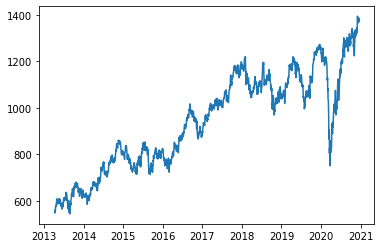

In [18]:
if "Date" in df.columns:
    #Id date is in columns, i.e. it is not set as the index yet.
    df.sort_values("Date", inplace=True)    #Sort the data according to the dates
    df= df.set_index("Date")    #Set date as the index

    df = get_indicators(df) #Get indicators for the stock
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]    #Training dataset
    df_data_test = df[df.index >= split_date]   #Test dataset
    
plt.plot(df.index,df["open"])

In [19]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2013-04-09,552.910202,556.588394,544.042201,549.439191,7516458.0,-19.100873,-17.587090,-1.513782,558.080299,591.424200,28.953101,16.576452,-0.067290,0.440809,-0.152651
2013-04-10,548.529591,557.185002,545.237993,555.579199,6435550.6,-18.155019,-17.700676,-0.454343,556.303578,588.898273,34.229528,16.245777,-0.044446,0.449421,-0.098895
2013-04-11,560.019998,562.732797,549.510406,553.878603,8542662.8,-17.342731,-17.629087,0.286356,554.529279,587.096000,33.487710,16.029821,-0.034822,0.456932,-0.076209
2013-04-12,549.156801,561.877991,547.306198,558.253001,5555212.8,-16.159730,-17.335216,1.175486,553.339598,585.154787,37.254577,15.925676,-0.040025,0.464543,-0.086160
2013-04-15,554.620996,567.554004,552.588399,559.999985,7132245.6,-14.909361,-16.850045,1.940684,552.704756,583.344800,38.746560,15.857100,-0.029734,0.471096,-0.063117


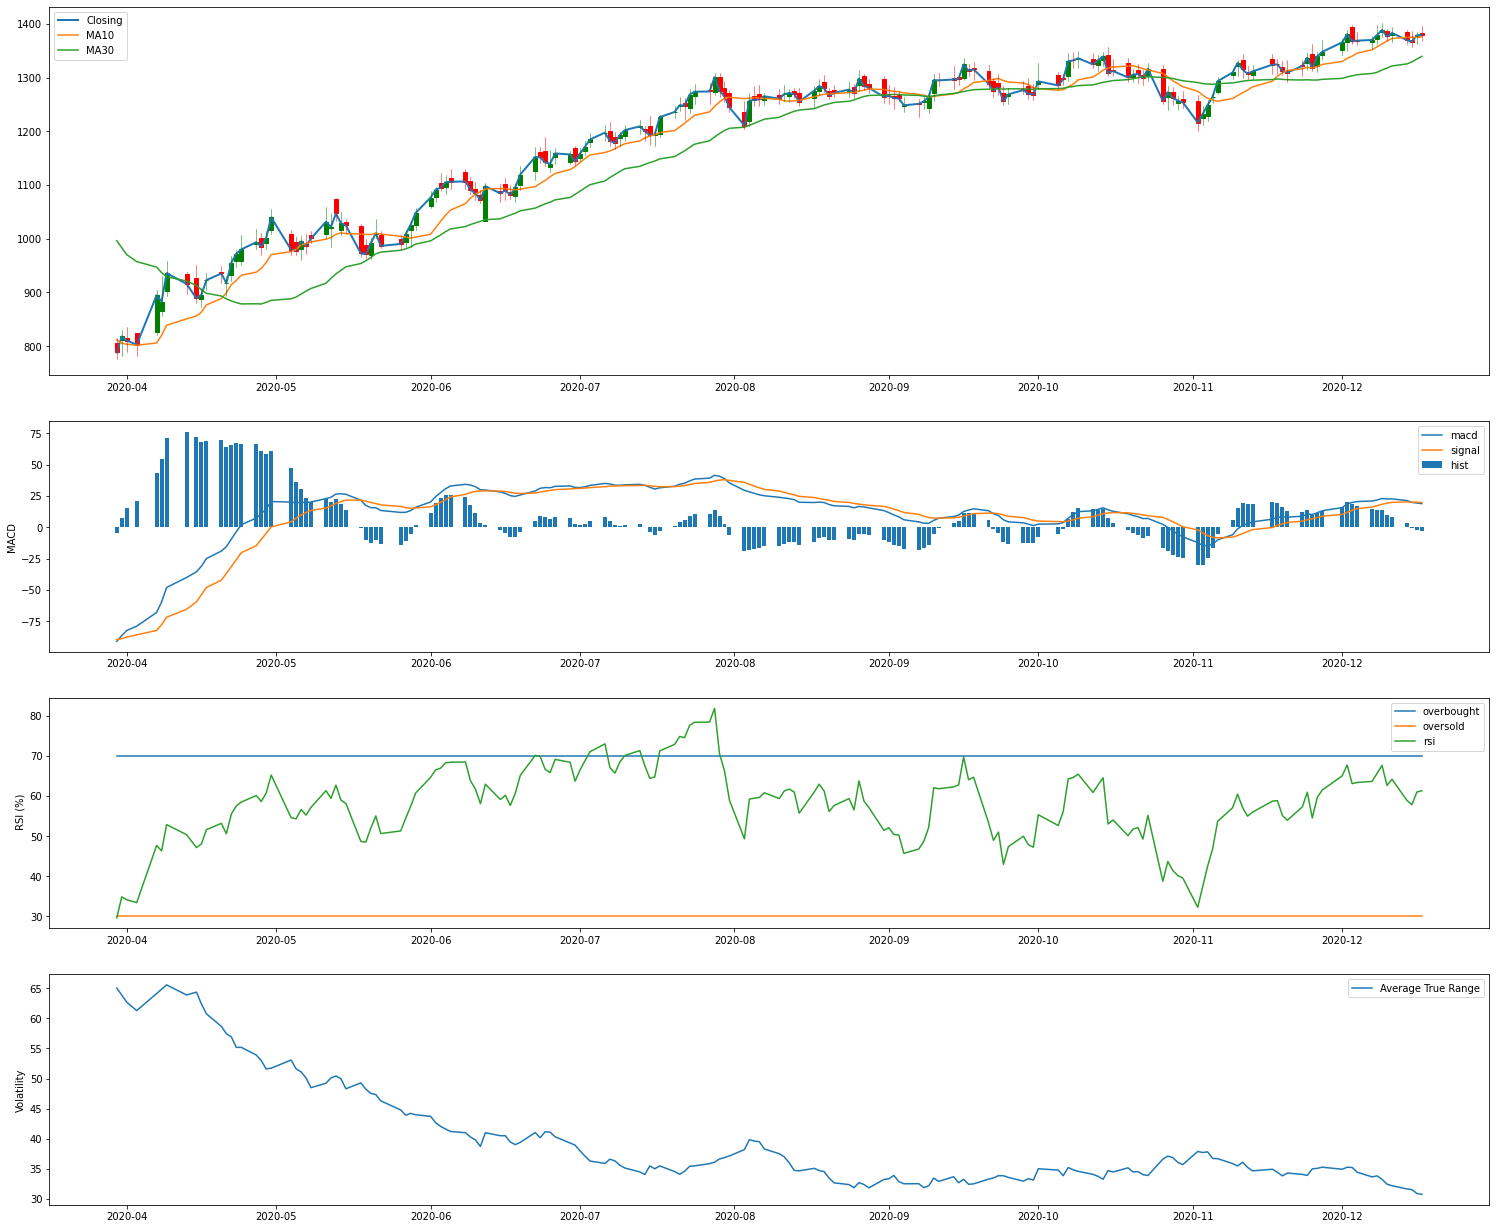

In [20]:
plot_chart(df, 180, 'Current Portfolio', save=img_save)

Training Size : 1652, Test Size : 241


Text(0.5, 0, 'Date')

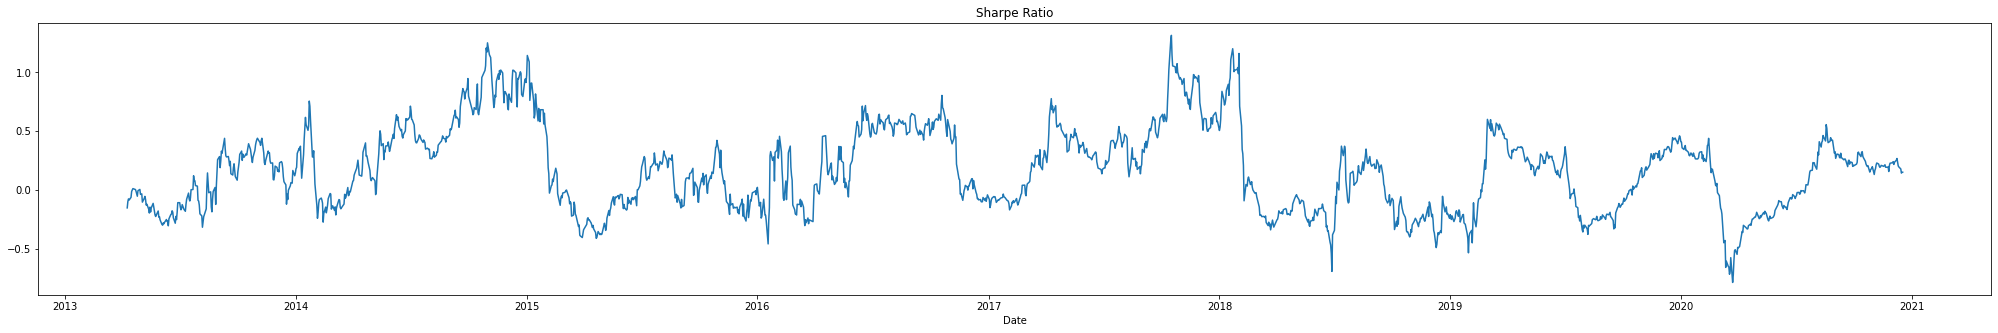

In [21]:
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )

plt.figure(figsize=(35,5))
plt.plot(df.index, df["Sharpe Ratio"])
plt.title("Sharpe Ratio")
plt.xlabel("Date")

In [22]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

## Scaler
Scales and normalizes the data for optimum operation by the neural network

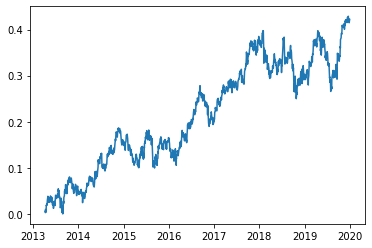

In [23]:
scaler = MinMaxScaler(feature_range=(0,0.5))    #Setting feature range to less than 1 allows to deal with data that is not yet seen by the neural network.
scaler.fit(df)  #Scales the dataframe

training_Dataset = scaler.transform(data_training)  #obtain the training dataset
_scale = [1/scaler.scale_[i] for i in target_prediction_indices]    #Multiplier of the scaler for each target indice
_intercept = [scaler.data_min_[i] for i in target_prediction_indices]   #Intercept of the scaler for each target indice

plt.plot(data_training.index, training_Dataset[:,0])

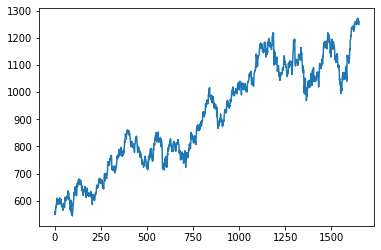

In [24]:
_df = scaler.inverse_transform(training_Dataset)
plt.plot(_df[:,0])

1652 1893


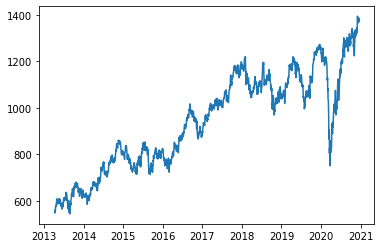

In [25]:
print(len(data_training), len(df))
plt.plot(df.index,df["open"])

## Training Pipeline

In [26]:
'''
We first break down our data to the training data and the labels.
The training data is a array of shape (Training_window, features). label is the target index of the dataframe incremented by the prediction window.
'''
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]-prediction_window):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i+prediction_window,target_prediction_indices])
#Obtain the array forms of the training data.
X_train, y_train = np.array(X_train), np.array(y_train)

In [27]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of X is : (1587, 60, 15), Shape of Y is : (1587, 3)
Shape of data_training.index (1592,)


In [28]:
'''
Callback to terminate the training prematurely to prevent overfitting.
'''
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 0.0070:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [29]:
'''
Network architecture
LSTM Model for training the neural network.
'''
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,15)),
    Dropout(0.4),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=70, activation='relu'),
    Dropout(0.3),
    Dense(3)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           65280     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [30]:
'''
Load the weights from the pretrained model to reduce training time.
'''
model.load_weights(model_name) if os.path.exists(model_name) else None
model_name

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/Final Version/data/portfolio_predictor_5.hdf5'

In [31]:
'''
Training pipeline for the model.
Optimizer : RMS Prop
Loss : Mean squared error
'''
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError(),metrics=["accuracy"])
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=40, callbacks = CustomCallback())

Epoch 1/40
50/50 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9074
Final Loss : 0.0050424933433532715
50/50 [==============================] - 6s 122ms/step - loss: 0.0050 - accuracy: 0.9074


In [32]:
test_pred = model.predict(X_train)
test_pred * _scale + _intercept

array([[6.13449200e+02, 4.01169410e-02, 2.83124845e-01],
       [6.13626853e+02, 4.08710061e-02, 2.83126973e-01],
       [6.13812433e+02, 4.17616704e-02, 2.83121556e-01],
       ...,
       [1.14185628e+03, 4.26976580e-02, 3.14938460e-01],
       [1.14170542e+03, 4.17249712e-02, 3.15492477e-01],
       [1.14157767e+03, 4.08022659e-02, 3.16020807e-01]])

In [33]:
'''
Testing the model
'''
model.evaluate(X_train, y_train)
test_pred
test_pred = test_pred * _scale + _intercept
y_train = y_train * _scale + _intercept

y_train

50/50 [==============================] - 1s 28ms/step - loss: 0.0014 - accuracy: 0.8885


array([[ 6.08179591e+02, -2.69286782e-02,  3.40578438e-01],
       [ 6.07900787e+02, -9.00031649e-03,  3.36083670e-01],
       [ 6.08767209e+02, -2.51406498e-02,  3.31094856e-01],
       ...,
       [ 1.24915000e+03,  1.86514334e-01,  4.74289290e-01],
       [ 1.25860999e+03,  2.22040650e-01,  4.82298027e-01],
       [ 1.26124999e+03,  2.17563273e-01,  4.88787057e-01]])

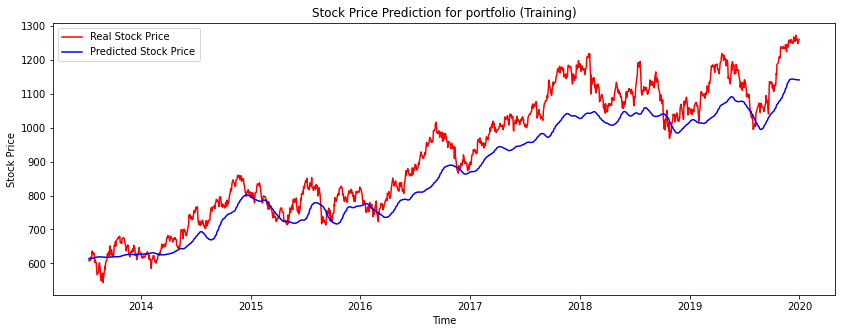

In [34]:
'''
Visualizing the training output.
'''
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window+prediction_window:], y_train[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window+prediction_window:], test_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio (Training)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
# plt.ylim(0,y_train.max()*1.1)
plt.savefig(result_path + "training_output.jpeg", dpi=300) if img_save else None
plt.show()

In [35]:
'''
We append the last training window data to the test to allow us to validate the first test value
'''
past_60_days = df_data_training.tail(training_window)
df_data_test.shape

(241, 15)

In [36]:
'''
Creating the Test Data
'''
df_test = past_60_days.append(df_data_test).sort_index()
df_test.dropna(inplace=True)
df_test.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2019-10-01,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373,-0.049109,0.407729,-0.120446
2019-10-03,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703,-0.028057,0.404647,-0.069337
2019-10-04,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080,-0.038763,0.402544,-0.096296
2019-10-07,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576,-0.028916,0.399248,-0.072427
2019-10-09,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678,-0.013274,0.396355,-0.033491


In [37]:
'''
Scales the test data
'''
inputs = scaler.transform(df_test)
inputs

array([[0.34751653, 0.35024853, 0.34252703, ..., 0.21543788, 0.14793497,
        0.1585339 ],
       [0.33755751, 0.34151733, 0.34057867, ..., 0.22540478, 0.14639182,
        0.17069108],
       [0.34350118, 0.34243547, 0.33772425, ..., 0.22033596, 0.14533904,
        0.16427833],
       ...,
       [0.48570229, 0.49136355, 0.48886063, ..., 0.27416306, 0.20579919,
        0.22124384],
       [0.48945897, 0.49055797, 0.49250269, ..., 0.27612455, 0.20661721,
        0.22301519],
       [0.49326857, 0.49763061, 0.49578943, ..., 0.27636011, 0.20748847,
        0.22312151]])

In [38]:
'''
Prepare the test data in the same manner as the training data.
'''
X_test = []
y_test = []

for i in range(training_window, inputs.shape[0]-prediction_window):
    X_test.append(inputs[i-training_window:i])
    y_test.append(inputs[i+prediction_window, target_prediction_indices])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((236, 60, 15), (236, 3))

In [39]:
'''
Obtain the predicted test data for model validation
'''
y_pred = model.predict(X_test)
y_pred = y_pred* _scale + _intercept
y_test = y_test* _scale + _intercept
y_pred.shape

(236, 3)

In [40]:
'''
Obtain the test score
'''
model.evaluate(X_test,  y_test)

8/8 [==============================] - 0s 40ms/step - loss: 466866.8750 - accuracy: 1.0000


[466866.875, 1.0]

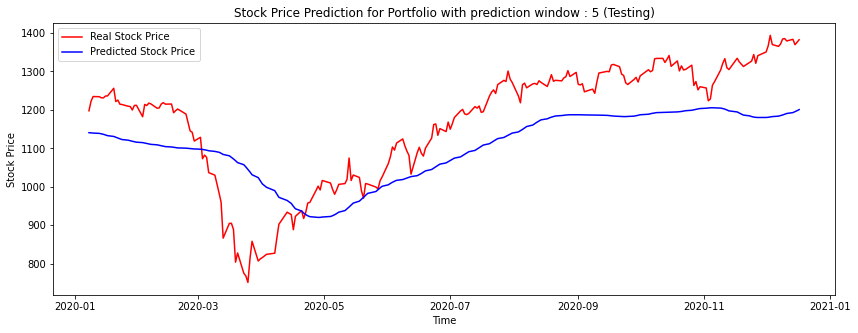

In [41]:
'''
Visualize the test data.
'''
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df_test.index[training_window+prediction_window:], y_test[:,0], color = 'red', label = 'Real Stock Price')
plt.plot(df_test.index[training_window+prediction_window:], y_pred[:,0], color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio with prediction window : '+ str(prediction_window)+' (Testing)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
y_test
# plt.ylim(0,y_test.max()*1.1)
plt.savefig(result_path + "test_output.jpeg", dpi=300) if img_save else None
plt.show()

## Updated Portfolio Analysis and Co-relation

In [42]:
def analyze_portfolio(stocks_df_ticker, external_stock_ticker, num_iterations=1000,show_figure=True,img_save=False):
    '''
    Function to analyze the portfolio with each of the external stocks to obtain the optimum portfolio allocation for maximizing the sharpe ratio and reduce volatility to the minumum.and

    :param stocks_df_ticker: Stock tickers of the current portfolio
    :param external_stock_ticker: Stock tickers of the stocks that are candidates for addition.
    :param num_iterations: Number of iterations for analysis. Higher the value, more accurate the distribution.
    :param show_figure: Weather to show the figure
    :param img_save: Weather to save the image.
   
    '''
    stocks_df = {}
    
    for stock in stocks.keys():
        # print("pulling data for ", stock)
        _df = si.get_data(stock)
        _df.dropna(inplace=True)
        stocks_df[stock] = _df

    analyze_stocks_df = stocks_df.copy()
    if external_stock_ticker:
        for stock in external_stock_ticker:
            # print("pulling data for ", stock)
            analyze_stocks_df[stock] = si.get_data(stock)
        
    stock = list(analyze_stocks_df.keys())
    num_stocks = len(stock)
    
    df = None
    for st in stock:
        if df is None:
            df = analyze_stocks_df[st].copy()
            df[st] = (df["open"] + df["close"])/2
            df = pd.DataFrame(df[st])
        else:
            _df = analyze_stocks_df[st]
            df[st] = (_df["open"] + _df["close"])/2
    df.dropna(inplace=True)   

    #Analyze stocks 
    stock_ret = df.pct_change()*100

    mean_returns = stock_ret.mean()
    cov_matrix = stock_ret.cov()


    simulation_res = np.zeros((4+num_stocks-1,num_iterations))

    for i in range(num_iterations):
    #Select random weights and normalize to set the sum to 1
        weights = np.array(np.random.random(num_stocks))
        weights /= np.sum(weights)
    #Calculate the return and standard deviation for every step
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
    #Store all the results in a defined array
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
    #Calculate Sharpe ratio and store it in the array
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
    #Save the weights in the array
        for j in range(len(weights)):
            simulation_res[j+3,i] = weights[j]
    sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe']+stock)
    
    #Spot the position of the portfolio with highest Sharpe Ratio
    max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

    #Spot the position of the portfolio with minimum Standard Deviation
    min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]

    if show_figure:
        plt.figure()
        plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
        plt.xlabel('Standard Deviation')
        plt.ylabel('Returns')
        plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=200, label="Maximum Sharpe Ratio")
        plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=200, label="Minimum Standard Deviation")
        plt.legend()
        plt.savefig(result_path + ",".join(external_stock_ticker) + ".jpeg", dpi=300) if img_save else None
        plt.close()
    max_sharpe = simulation_res[2,:].max()

    for it in range(num_iterations):
        if simulation_res[2,it] == max_sharpe:
            break

    a = list(zip(stock,simulation_res[:,it][-num_stocks:]))
    extended_stock_df = dict(a)
    fig = plt.figure()
    plt.pie([val for key,val in extended_stock_df.items()], labels=[key for key,val in extended_stock_df.items()], 
        autopct=lambda pct: '{0:.2f} %'.format(pct))
    # print("Saving fig for ", str(external_stock_ticker ))
    plt.savefig(result_path + "Optimized portfolio - "+",".join(external_stock_ticker) + ".jpeg", dpi=300) if img_save else None
    plt.close()
    return extended_stock_df

In [43]:
def projected_returns_with_optimised_portfolio(extended_stock_df_tickers):
    '''
    Project the opening prices for the optimized portfolio in the prediction window.
    :param extended_stock_df_tickers: Stock tickers to analyze the portfolio with.
    '''
    df = None
    for stock in extended_stock_df.keys():
        _df = si.get_data(stock)
        _df.dropna(inplace=True)
        stocks_df[stock] = _df
        if df is None:
            df = _df[cols_to_keep]*extended_stock_df.get(stock)
            indices = set(df.index.astype('str').tolist())
        else:
            indices = indices.intersection(set(_df.index.astype('str').tolist()))
            df = df.loc[indices]
            _df = _df.loc[indices]
            df[cols_to_keep] += _df[cols_to_keep]*extended_stock_df.get(stock)
    
    get_indicators(df)
    df.dropna(inplace=True)
    df = df.sort_index()
    dataset = scaler.transform(df)
    
    X = []
    for i in range(-prediction_window,0):
        X.append(dataset[i-training_window:i])
    
    Y = model.predict(np.array(X)) * _scale + _intercept
    dt = df.index[-prediction_window:] + timedelta(prediction_window)

    return dt, Y



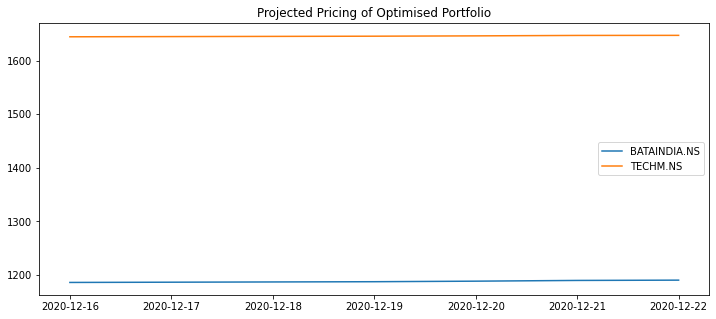

In [44]:
inportfolio_tickers = list(load_stocks(input_path).keys()) #Tickers for the stocks inside the portfolio
external_stock_ticker = load_external_stocks(external_stock_input_path) #TIckers of the stocks on the candidate list
projected_returns = {}  #Dictionary to hold the projected returns for each ticker.

for st in external_stock_ticker:
    extended_stock_df = analyze_portfolio(inportfolio_tickers, [st], img_save=img_save)
    dt, Y = projected_returns_with_optimised_portfolio(extended_stock_df)
    projected_returns[st] = [dt,Y]

fig = plt.figure(figsize=(12,5))
plt.title("Projected Pricing of Optimised Portfolio")

for st in external_stock_ticker:
    _dt, _Y = projected_returns[st]
    plt.plot(_dt, _Y[:,0], label=st)
    plt.legend()
    plt.savefig(result_path + "Optimized portfolio projection"+ ".jpeg", dpi=300) if img_save else None


## Asset Co-relation
Obtain the asset correlation and the heat map.

In [71]:

def get_correlation(s1,s2):
    '''
    Get the correlation for stocks s1 and s2.
    :param s1: Stock 1 closing dataframe 
    :param s2: Stock 2 closing dataframe
    :return: Get the pearson r correlation.
    '''
    real = pearsonr(s1, s2)
    return real[0]

In [72]:
'''
Dataframe to obtain the correlation between each stock.
'''
index = list(stocks_df.keys())
data = {}

for st1 in index:
    data[st1] = [get_correlation( stocks_df[st1]["close"][-training_window-prediction_window:] , stocks_df[st2]["close"][-training_window-prediction_window:]) for st2 in index]

data['index'] = index
data = pd.DataFrame(data)
data.set_index('index', inplace=True)   #Dataframe with asset correlation between each stock

In [69]:
data

,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS,BATAINDIA.NS,TECHM.NS
index,,,,,,,
YESBANK.NS,1.000000,0.814258,0.555084,-0.334019,0.843679,0.836249,0.732637
TATAMOTORS.NS,0.814258,1.000000,0.784504,-0.578331,0.860357,0.923805,0.793148
HDFCBANK.NS,0.555084,0.784504,1.000000,-0.806502,0.647114,0.746158,0.776315
RELIANCE.NS,-0.334019,-0.578331,-0.806502,1.000000,-0.357227,-0.517867,-0.510866
BAJAJ-AUTO.NS,0.843679,0.860357,0.647114,-0.357227,1.000000,0.907368,0.884274
BATAINDIA.NS,0.836249,0.923805,0.746158,-0.517867,0.907368,1.000000,0.851367
TECHM.NS,0.732637,0.793148,0.776315,-0.510866,0.884274,0.851367,1.000000


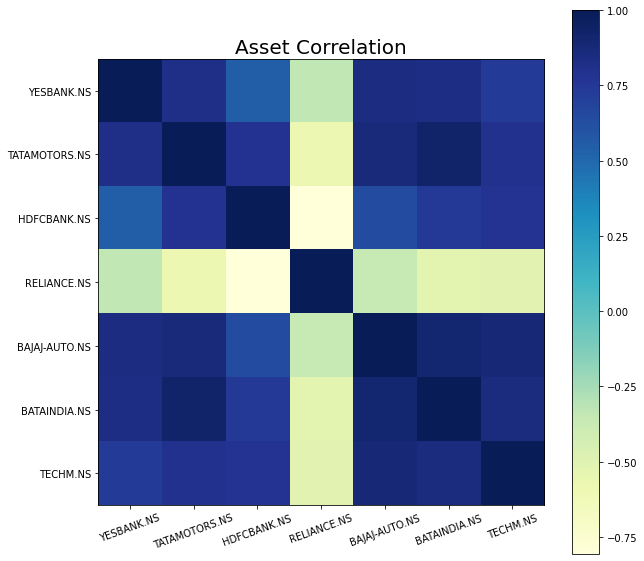

In [70]:
'''
Visualize the asset correlation as a heat map.
'''
plt.figure(figsize=(10,10))
plt.title("Asset Correlation",fontsize=20)
plt.imshow(data, cmap="YlGnBu")
plt.colorbar()
plt.xticks(range(len(data)),data.columns, rotation=20)
plt.yticks(range(len(data)),data.index)

plt.savefig(result_path + "Asset Correlation Heat Map") if img_save else None

## Unit Tests

In [265]:
import unittest

class Tests(unittest.TestCase):

    def get_data(arg):
        sample_data_1 = {'open': {Timestamp('2012-06-19 00:00:00'): 1540.0,
                                Timestamp('2012-06-20 00:00:00'): 1535.0,
                                Timestamp('2012-06-21 00:00:00'): 1531.800048828125,
                                Timestamp('2012-06-22 00:00:00'): 1524.0,
                                Timestamp('2012-06-25 00:00:00'): 1546.25,
                                Timestamp('2012-06-26 00:00:00'): 1549.75,
                                Timestamp('2012-06-27 00:00:00'): 1562.4000244140625,
                                Timestamp('2012-06-28 00:00:00'): 1560.0,
                                Timestamp('2012-06-29 00:00:00'): 1571.0},
                                'high': {Timestamp('2012-06-19 00:00:00'): 1545.1500244140625,
                                Timestamp('2012-06-20 00:00:00'): 1541.0,
                                Timestamp('2012-06-21 00:00:00'): 1545.0,
                                Timestamp('2012-06-22 00:00:00'): 1558.8499755859375,
                                Timestamp('2012-06-25 00:00:00'): 1559.8499755859375,
                                Timestamp('2012-06-26 00:00:00'): 1567.0,
                                Timestamp('2012-06-27 00:00:00'): 1568.800048828125,
                                Timestamp('2012-06-28 00:00:00'): 1567.0,
                                Timestamp('2012-06-29 00:00:00'): 1579.0},
                                'low': {Timestamp('2012-06-19 00:00:00'): 1526.0,
                                Timestamp('2012-06-20 00:00:00'): 1528.6500244140625,
                                Timestamp('2012-06-21 00:00:00'): 1516.199951171875,
                                Timestamp('2012-06-22 00:00:00'): 1524.0,
                                Timestamp('2012-06-25 00:00:00'): 1538.0999755859375,
                                Timestamp('2012-06-26 00:00:00'): 1542.0,
                                Timestamp('2012-06-27 00:00:00'): 1551.949951171875,
                                Timestamp('2012-06-28 00:00:00'): 1545.0,
                                Timestamp('2012-06-29 00:00:00'): 1556.0999755859375},
                                'close': {Timestamp('2012-06-19 00:00:00'): 1535.4000244140625,
                                Timestamp('2012-06-20 00:00:00'): 1535.199951171875,
                                Timestamp('2012-06-21 00:00:00'): 1536.25,
                                Timestamp('2012-06-22 00:00:00'): 1545.4000244140625,
                                Timestamp('2012-06-25 00:00:00'): 1548.4000244140625,
                                Timestamp('2012-06-26 00:00:00'): 1558.3499755859375,
                                Timestamp('2012-06-27 00:00:00'): 1558.75,
                                Timestamp('2012-06-28 00:00:00'): 1550.25,
                                Timestamp('2012-06-29 00:00:00'): 1572.8499755859375},
                                'adjclose': {Timestamp('2012-06-19 00:00:00'): 1226.524169921875,
                                Timestamp('2012-06-20 00:00:00'): 1226.3643798828125,
                                Timestamp('2012-06-21 00:00:00'): 1227.203125,
                                Timestamp('2012-06-22 00:00:00'): 1234.5125732421875,
                                Timestamp('2012-06-25 00:00:00'): 1236.908935546875,
                                Timestamp('2012-06-26 00:00:00'): 1244.8572998046875,
                                Timestamp('2012-06-27 00:00:00'): 1245.177001953125,
                                Timestamp('2012-06-28 00:00:00'): 1238.38671875,
                                Timestamp('2012-06-29 00:00:00'): 1256.4404296875},
                                'volume': {Timestamp('2012-06-19 00:00:00'): 199100.0,
                                Timestamp('2012-06-20 00:00:00'): 527580.0,
                                Timestamp('2012-06-21 00:00:00'): 618693.0,
                                Timestamp('2012-06-22 00:00:00'): 435310.0,
                                Timestamp('2012-06-25 00:00:00'): 292270.0,
                                Timestamp('2012-06-26 00:00:00'): 330128.0,
                                Timestamp('2012-06-27 00:00:00'): 289380.0,
                                Timestamp('2012-06-28 00:00:00'): 330958.0,
                                Timestamp('2012-06-29 00:00:00'): 373990.0},
                                'ticker': {Timestamp('2012-06-19 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-20 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-21 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-22 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-25 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-26 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-27 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-28 00:00:00'): 'BAJAJ-AUTO.NS',
                                Timestamp('2012-06-29 00:00:00'): 'BAJAJ-AUTO.NS'}}

        sample_data_2 = {'open': {Timestamp('1996-01-02 00:00:00'): 16.029300689697266,
                        Timestamp('1996-01-03 00:00:00'): 16.204999923706055,
                        Timestamp('1996-01-04 00:00:00'): 15.912099838256836,
                        Timestamp('1996-01-05 00:00:00'): 15.853599548339844,
                        Timestamp('1996-01-08 00:00:00'): 15.775500297546387,
                        Timestamp('1996-01-09 00:00:00'): 14.725099563598633,
                        Timestamp('1996-01-10 00:00:00'): 14.447799682617188,
                        Timestamp('1996-01-11 00:00:00'): 14.213500022888184,
                        Timestamp('1996-01-12 00:00:00'): 14.916399955749512},
                        'high': {Timestamp('1996-01-02 00:00:00'): 16.10740089416504,
                        Timestamp('1996-01-03 00:00:00'): 16.94300079345703,
                        Timestamp('1996-01-04 00:00:00'): 15.962900161743164,
                        Timestamp('1996-01-05 00:00:00'): 15.853599548339844,
                        Timestamp('1996-01-08 00:00:00'): 15.787199974060059,
                        Timestamp('1996-01-09 00:00:00'): 14.994500160217285,
                        Timestamp('1996-01-10 00:00:00'): 14.79539966583252,
                        Timestamp('1996-01-11 00:00:00'): 14.877400398254395,
                        Timestamp('1996-01-12 00:00:00'): 15.029600143432617},
                        'low': {Timestamp('1996-01-02 00:00:00'): 15.826199531555176,
                        Timestamp('1996-01-03 00:00:00'): 16.029300689697266,
                        Timestamp('1996-01-04 00:00:00'): 15.701299667358398,
                        Timestamp('1996-01-05 00:00:00'): 15.670000076293945,
                        Timestamp('1996-01-08 00:00:00'): 15.017900466918945,
                        Timestamp('1996-01-09 00:00:00'): 14.233099937438965,
                        Timestamp('1996-01-10 00:00:00'): 14.291600227355957,
                        Timestamp('1996-01-11 00:00:00'): 14.194000244140625,
                        Timestamp('1996-01-12 00:00:00'): 14.553299903869629},
                        'close': {Timestamp('1996-01-02 00:00:00'): 15.943400382995605,
                        Timestamp('1996-01-03 00:00:00'): 16.06439971923828,
                        Timestamp('1996-01-04 00:00:00'): 15.916000366210938,
                        Timestamp('1996-01-05 00:00:00'): 15.806699752807617,
                        Timestamp('1996-01-08 00:00:00'): 15.174099922180176,
                        Timestamp('1996-01-09 00:00:00'): 14.736800193786621,
                        Timestamp('1996-01-10 00:00:00'): 14.357999801635742,
                        Timestamp('1996-01-11 00:00:00'): 14.807100296020508,
                        Timestamp('1996-01-12 00:00:00'): 14.650899887084961},
                        'adjclose': {Timestamp('1996-01-02 00:00:00'): 2.403214693069458,
                        Timestamp('1996-01-03 00:00:00'): 2.4214534759521484,
                        Timestamp('1996-01-04 00:00:00'): 2.3990845680236816,
                        Timestamp('1996-01-05 00:00:00'): 2.3826091289520264,
                        Timestamp('1996-01-08 00:00:00'): 2.287254810333252,
                        Timestamp('1996-01-09 00:00:00'): 2.2213385105133057,
                        Timestamp('1996-01-10 00:00:00'): 2.164240598678589,
                        Timestamp('1996-01-11 00:00:00'): 2.2319352626800537,
                        Timestamp('1996-01-12 00:00:00'): 2.208390951156616},
                        'volume': {Timestamp('1996-01-02 00:00:00'): 77143764.0,
                        Timestamp('1996-01-03 00:00:00'): 95695836.0,
                        Timestamp('1996-01-04 00:00:00'): 99159504.0,
                        Timestamp('1996-01-05 00:00:00'): 76213503.0,
                        Timestamp('1996-01-08 00:00:00'): 85478335.0,
                        Timestamp('1996-01-09 00:00:00'): 177730990.0,
                        Timestamp('1996-01-10 00:00:00'): 126455257.0,
                        Timestamp('1996-01-11 00:00:00'): 187276245.0,
                        Timestamp('1996-01-12 00:00:00'): 171294714.0},
                        'ticker': {Timestamp('1996-01-02 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-03 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-04 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-05 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-08 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-09 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-10 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-11 00:00:00'): 'RELIANCE.NS',
                        Timestamp('1996-01-12 00:00:00'): 'RELIANCE.NS'}}

        return pd.DataFrame(sample_data_1), pd.DataFrame(sample_data_2)

    def test_get_correlation_1(self):
        s1 = range(1,10)
        s2 = range(10,1,-1)
        output = get_correlation(s1,s2)
        self.assertAlmostEqual(output,-1)

    def test_get_correlation_2(self):
        s1 = range(1,10)
        s2 = range(1,10)
        output = get_correlation(s1,s2)
        self.assertAlmostEqual(output,1)
    
    def test_get_correlation_3(self):
        df1, df2 = self.get_data()
        output = get_correlation(df1["open"],df2["open"])
        self.assertAlmostEqual(output,-0.8,places=2)
    
    def test_get_indicators(self):
        df1, df2 = self.get_data()
        df = pd.concat([_df1]*22).reset_index().drop('index',axis=1)
        print(df.head())
        # a = get_indicators(df, window=22)
        # print(a)


In [266]:
# df1, df2 = Tests().get_data()
# df = pd.concat([_df1]*23).reset_index().drop('index',axis=1)
# get_indicators(df[cols_to_keep])

            open         high          low        close    volume      macd  \
199  1535.000000  1541.000000  1528.650024  1535.199951  527580.0 -0.498069   
200  1531.800049  1545.000000  1516.199951  1536.250000  618693.0 -1.429197   
201  1524.000000  1558.849976  1524.000000  1545.400024  435310.0 -1.412510   
202  1546.250000  1559.849976  1538.099976  1548.400024  292270.0 -1.144022   
203  1549.750000  1567.000000  1542.000000  1558.349976  330128.0 -0.126903   
204  1562.400024  1568.800049  1551.949951  1558.750000  289380.0  0.703342   
205  1560.000000  1567.000000  1545.000000  1550.250000  330958.0  0.667741   
206  1571.000000  1579.000000  1556.099976  1572.849976  373990.0  2.435086   

     macd_signal  macd_hist         ma10         ma30        rsi        ATR  \
199     0.336462  -0.834531  1547.604993  1548.866663  45.301889  26.216820   
200    -0.016670  -1.412527  1547.709998  1547.646663  45.693218  26.401337   
201    -0.295838  -1.116672  1548.625000  1547.9799

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
199,1535.000000,1541.000000,1528.650024,1535.199951,527580.0,-0.498069,0.336462,-0.834531,1547.604993,1548.866663,45.301889,26.216820,-0.000130,0.045844,-0.002843
200,1531.800049,1545.000000,1516.199951,1536.250000,618693.0,-1.429197,-0.016670,-1.412527,1547.709998,1547.646663,45.693218,26.401337,0.000684,0.045845,0.014914
201,1524.000000,1558.849976,1524.000000,1545.400024,435310.0,-1.412510,-0.295838,-1.116672,1548.625000,1547.979997,49.109874,27.004811,0.005938,0.045924,0.129309
202,1546.250000,1559.849976,1538.099976,1548.400024,292270.0,-1.144022,-0.465474,-0.678548,1548.925000,1548.419999,50.215790,26.629467,0.001939,0.045852,0.042296
203,1549.750000,1567.000000,1542.000000,1558.349976,330128.0,-0.126903,-0.397760,0.270857,1549.919995,1549.156665,53.801699,26.513077,0.006405,0.045937,0.139437
204,1562.400024,1568.800049,1551.949951,1558.750000,289380.0,0.703342,-0.177540,0.880882,1549.959998,1549.601664,53.945325,25.822864,0.000257,0.045844,0.005599
205,1560.000000,1567.000000,1545.000000,1550.250000,330958.0,0.667741,-0.008484,0.676224,1549.109998,1549.663330,50.362466,25.549802,-0.005468,0.045912,-0.119098
206,1571.000000,1579.000000,1556.099976,1572.849976,373990.0,2.435086,0.480230,1.954855,1551.369995,1550.146663,58.293861,25.778388,0.014473,0.046321,0.312452


In [254]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

......          open         high          low        close     adjclose    volume  \
0  1540.000000  1545.150024  1526.000000  1535.400024  1226.524170  199100.0   
1  1535.000000  1541.000000  1528.650024  1535.199951  1226.364380  527580.0   
2  1531.800049  1545.000000  1516.199951  1536.250000  1227.203125  618693.0   
3  1524.000000  1558.849976  1524.000000  1545.400024  1234.512573  435310.0   
4  1546.250000  1559.849976  1538.099976  1548.400024  1236.908936  292270.0   

          ticker  
0  BAJAJ-AUTO.NS  
1  BAJAJ-AUTO.NS  
2  BAJAJ-AUTO.NS  
3  BAJAJ-AUTO.NS  
4  BAJAJ-AUTO.NS  

----------------------------------------------------------------------
Ran 6 tests in 0.033s

OK


In [234]:
_df1 = stocks_df["BAJAJ-AUTO.NS"][1:10]
_df2 = stocks_df["RELIANCE.NS"][1:10]

In [191]:
a = _df1.to_dict()
b = _df2.to_dict()
_df1.head

<bound method NDFrame.head of                    open         high          low        close     adjclose  \
2012-06-19  1540.000000  1545.150024  1526.000000  1535.400024  1226.524170   
2012-06-20  1535.000000  1541.000000  1528.650024  1535.199951  1226.364380   
2012-06-21  1531.800049  1545.000000  1516.199951  1536.250000  1227.203125   
2012-06-22  1524.000000  1558.849976  1524.000000  1545.400024  1234.512573   
2012-06-25  1546.250000  1559.849976  1538.099976  1548.400024  1236.908936   
2012-06-26  1549.750000  1567.000000  1542.000000  1558.349976  1244.857300   
2012-06-27  1562.400024  1568.800049  1551.949951  1558.750000  1245.177002   
2012-06-28  1560.000000  1567.000000  1545.000000  1550.250000  1238.386719   
2012-06-29  1571.000000  1579.000000  1556.099976  1572.849976  1256.440430   

              volume         ticker  
2012-06-19  199100.0  BAJAJ-AUTO.NS  
2012-06-20  527580.0  BAJAJ-AUTO.NS  
2012-06-21  618693.0  BAJAJ-AUTO.NS  
2012-06-22  435310.0  BAJAJ

In [229]:
a = pd.concat([_df1]*30)
a = a.reset_index().drop("index",axis=1)
b = get_indicators(a)
b.dropna()

            open         high          low        close     adjclose  \
0    1540.000000  1545.150024  1526.000000  1535.400024  1226.524170   
1    1535.000000  1541.000000  1528.650024  1535.199951  1226.364380   
2    1531.800049  1545.000000  1516.199951  1536.250000  1227.203125   
3    1524.000000  1558.849976  1524.000000  1545.400024  1234.512573   
4    1546.250000  1559.849976  1538.099976  1548.400024  1236.908936   
..           ...          ...          ...          ...          ...   
265  1546.250000  1559.849976  1538.099976  1548.400024  1236.908936   
266  1549.750000  1567.000000  1542.000000  1558.349976  1244.857300   
267  1562.400024  1568.800049  1551.949951  1558.750000  1245.177002   
268  1560.000000  1567.000000  1545.000000  1550.250000  1238.386719   
269  1571.000000  1579.000000  1556.099976  1572.849976  1256.440430   

       volume         ticker      macd  macd_signal  macd_hist         ma10  \
0    199100.0  BAJAJ-AUTO.NS       NaN          NaN     

,open,high,low,close,adjclose,volume,ticker,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio


In [219]:
data = pd.concat([_df1]*8)
talib.MA(data["close"], timeperiod=10)

2012-06-19            NaN
2012-06-20            NaN
2012-06-21            NaN
2012-06-22            NaN
2012-06-25            NaN
                 ...     
2012-06-25    1548.925000
2012-06-26    1549.919995
2012-06-27    1549.959998
2012-06-28    1549.109998
2012-06-29    1551.369995
Length: 72, dtype: float64